In [1]:
import numpy as np
from keras.models import model_from_json
import tensorflow as tf
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import rasterio
import cv2
from PIL import Image
from skimage.transform import resize

In [2]:
model = tf.keras.models.load_model("prev_trained_model/model_weights_resnet.h5", compile=False)


In [3]:
image_file = 'DL52_9309_8_3.tif'

In [4]:
# import cv2
# import numpy as np

# image = cv2.imread('DL52_9309_8_3.tif', cv2.IMREAD_GRAYSCALE)

# # Blur
# blurred = cv2.GaussianBlur(image, (5, 5), 0)

# # Laplacian Sharpness
# sharpened = cv2.Laplacian(blurred, cv2.CV_8U, ksize=5)

# # Combine for more subtle sharpening
# sharpened = cv2.addWeighted(image, 1.5, sharpened, -0.5, 0)

# cv2.imshow("Sharpened Mask", sharpened)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [5]:
def features(image_file):
    img = load_img(image_file, color_mode='rgb')
    img = img_to_array(img)
    img = resize(img, (256,256))  # Resize the image to the expected shape
    img = np.expand_dims(img, axis=0)
    return img/255.

In [6]:
img = features(image_file)
pred = model.predict(img)

1/1 [==============================] - 4s 4s/step


In [7]:
pred

array([[[[0.26822197],
         [0.2487877 ],
         [0.22813004],
         ...,
         [0.39695615],
         [0.3953117 ],
         [0.4343259 ]],

        [[0.22853172],
         [0.15731205],
         [0.16829482],
         ...,
         [0.40639973],
         [0.43824404],
         [0.4126642 ]],

        [[0.21343733],
         [0.17906094],
         [0.18134   ],
         ...,
         [0.42309543],
         [0.4367046 ],
         [0.4385293 ]],

        ...,

        [[0.5667887 ],
         [0.55707526],
         [0.5314514 ],
         ...,
         [0.5513297 ],
         [0.5215184 ],
         [0.49016607]],

        [[0.54646415],
         [0.5299074 ],
         [0.57828885],
         ...,
         [0.51506245],
         [0.44058925],
         [0.4289294 ]],

        [[0.46530458],
         [0.5519049 ],
         [0.54564184],
         ...,
         [0.48009706],
         [0.5045882 ],
         [0.43290383]]]], dtype=float32)

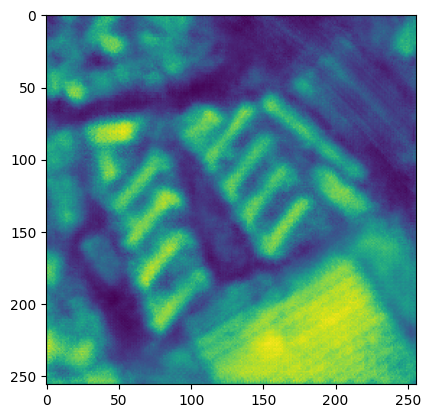

In [8]:
plt.imshow(pred[0])
plt.axis('on')  # Remove axis
plt.show()

In [9]:
class_labels = ['Background', 'Rooftop',...]
pred_mask = pred[0]

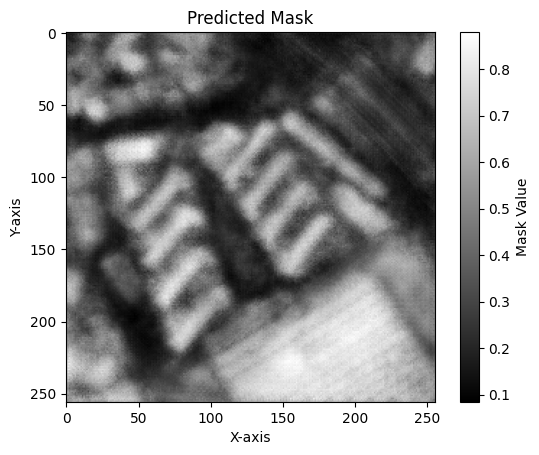

In [10]:
pred_mask = pred[0, :, :, 0]
fig, ax = plt.subplots()
im = ax.imshow(pred_mask, cmap='gray')
ax.set_title('Predicted Mask')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('Mask Value')


In [11]:
from scipy.ndimage import gaussian_filter

In [12]:
blurred_pred = gaussian_filter(pred[0], sigma=2)
sharpened_pred = pred[0]-blurred_pred

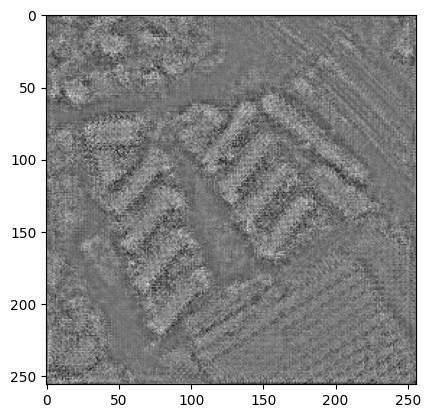

In [13]:
plt.imshow(sharpened_pred,cmap="grey")

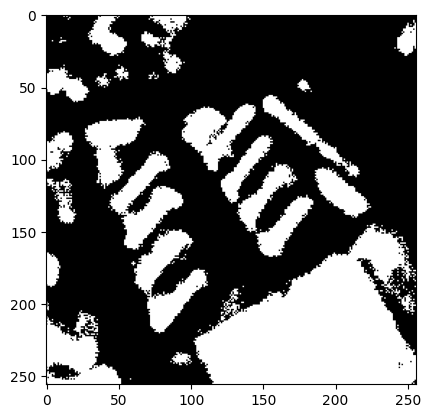

In [18]:
threshold = 0.5  # adjust this value as needed
binary_mask = (pred[0] > threshold).astype(np.uint8)
plt.imshow(binary_mask, cmap="grey")


In [19]:
original_image = cv2.imread('DL52_9309_8_3.tif')
resized_image = cv2.resize(original_image, (256, 256))
grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
image_array = grayscale_image.reshape((256, 256, 1))



In [20]:
result_image = image_array.copy()
result_image[binary_mask == 1] = (255)  

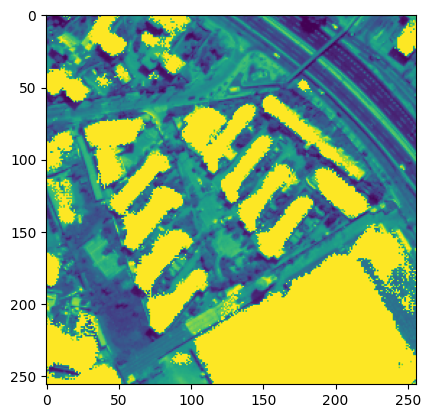

In [21]:
plt.imshow(result_image)
plt.show()

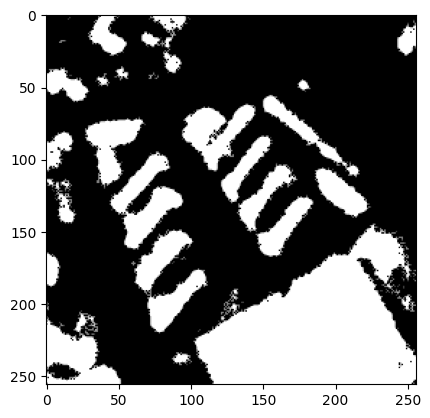

In [29]:
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

  # Apply unsharp masking
blurred = cv2.filter2D(binary_mask, -1, kernel)
sharpened = cv2.addWeighted(binary_mask, 5, blurred, -0.5, 250)
plt.imshow(sharpened, cmap="grey")

In [30]:
# assume 'predicted_mask' is a 2D numpy array representing the predicted mask

# ensure the predicted mask has values in the range [0, 255]
predicted_mask = (sharpened * 255).astype(np.uint8)

# create a PIL Image from the numpy array
image = Image.fromarray(sharpened)

# save the image to a .tif file
image.save('predicted_mask.tif')

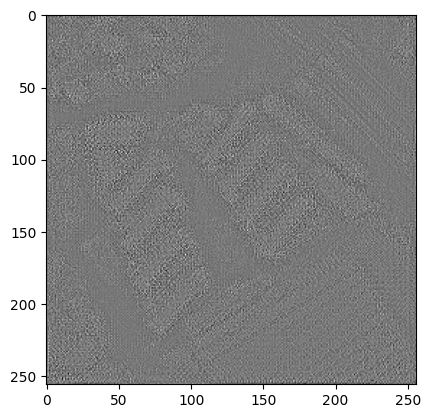

In [23]:
ksize = 5  # Adjust kernel size for desired effect
sigma = 0.5  # Adjust sigma for noise reduction
gaussian_kernel = cv2.getGaussianKernel(ksize, sigma) # Define high-pass filter kernel (Laplacian)
highpass_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

# Apply Gaussian filter
blurred = cv2.filter2D(pred[0], -1, gaussian_kernel)

# Apply high-pass filter
sharpened = cv2.filter2D(blurred, -1, highpass_kernel)
plt.imshow(sharpened , cmap="grey")

In [24]:
image_array_clipped = np.clip(sharpened, 0, None)
print(image_array_clipped)

[[0.11813654 0.10324377 0.05352089 ... 0.         0.         0.074489  ]
 [0.11260854 0.         0.         ... 0.         0.0659315  0.        ]
 [0.0628355  0.         0.         ... 0.01035565 0.01424438 0.02639672]
 ...
 [0.05041265 0.01936609 0.         ... 0.07988572 0.02925488 0.        ]
 [0.04589686 0.         0.08682752 ... 0.04564071 0.         0.        ]
 [0.         0.08335882 0.         ... 0.         0.13213211 0.        ]]


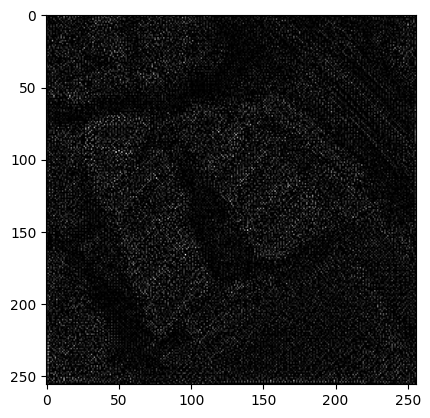

In [25]:
plt.imshow(image_array_clipped, cmap="grey")

In [26]:
masked_area = np.sum(image_array_clipped > 0)
print(f'Masked area: {masked_area} pixels')

Masked area: 32533 pixels
